In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
path_dataset_folder_1 = '/content/drive/MyDrive/CS231_data'


In [4]:
X_train = []
y_train = []
X_test = []
y_test = []

label_mapping = {}

sorted_folders = sorted(os.listdir(path_dataset_folder_1))

for idx, emotion_folder in enumerate(sorted_folders):
    emotion_path = os.path.join(path_dataset_folder_1, emotion_folder)
    if os.path.isdir(emotion_path):
        label_mapping[idx] = emotion_folder

        image_files = os.listdir(emotion_path)
        image_indices = list(range(len(image_files)))
        random.shuffle(image_indices)

        split_index = int(0.8 * len(image_indices))
        train_indices = image_indices[:split_index]
        test_indices = image_indices[split_index:]

        # Duyệt qua các hình ảnh trong thư mục cảm xúc
        for i, image_file in enumerate(image_files):
            image_path = os.path.join(emotion_path, image_file)

            image = cv.imread(image_path)
            image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

            if i in train_indices:
                X_train.append(image)
                y_train.append(idx)
            elif i in test_indices:
                X_test.append(image)
                y_test.append(idx)

# In kích thước của tập train và tập test
print("Kích thước của tập train:")
print("X_train:", len(X_train))
print("y_train:", len(y_train))
print("Kích thước của tập test:")
print("X_test:", len(X_test))
print("y_test:", len(y_test))

# In bảng ánh xạ nhãn
print("Bảng ánh xạ nhãn:")
print(label_mapping)

Kích thước của tập train:
X_train: 799
y_train: 799
Kích thước của tập test:
X_test: 202
y_test: 202
Bảng ánh xạ nhãn:
{0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'sadness', 6: 'surprise'}


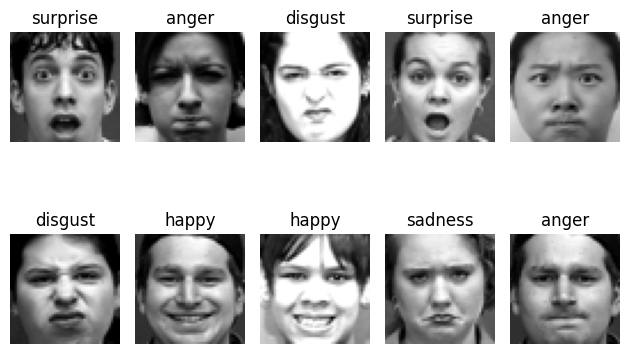

In [5]:


random_indices = random.sample(range(len(X_train)), 10)

for i in range(10):
    index = random_indices[i]
    image = X_train[index]
    label = label_mapping[y_train[index]]

    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
from skimage import feature

def compute_hog_train(train_images):
  train_features =[]
  hog_images = []
  for img in train_images:
    img =cv.resize(img, (128, 128))
    (hog, hog_image) = feature.hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True, transform_sqrt=True)
    train_features.append(hog)
    hog_images.append(hog_image)
  return train_features, hog_images


In [7]:
X_train_feature, X_train_hog_images = compute_hog_train(X_train)
X_test_feature, X_train_hog_images = compute_hog_train(X_test)

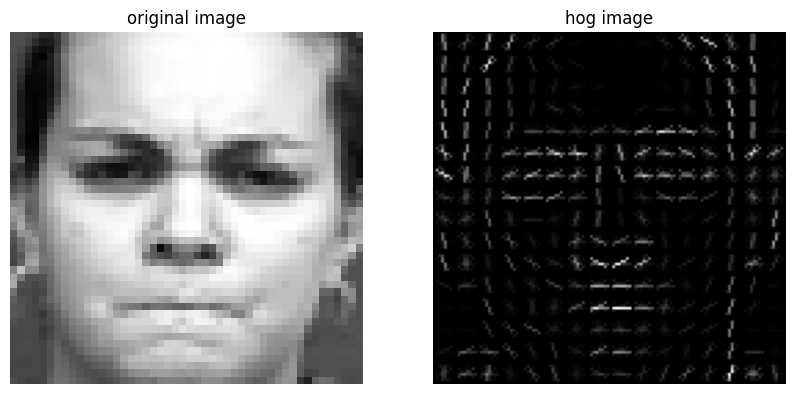

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[1].imshow(X_train_hog_images[0], cmap='gray')
axes[1].set_title('hog image')
axes[1].axis('off')
axes[0].imshow(X_train[0], cmap='gray')
axes[0].axis('off')
axes[0].set_title('original image')
plt.show()

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [10]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(1, 11))}


grid_search = GridSearchCV(knn, param_grid, cv=4, scoring = 'accuracy')
grid_search.fit(X_train_feature, y_train)

best_k = grid_search.best_params_['n_neighbors']
print("Best K:", best_k)

best_model = KNeighborsClassifier(n_neighbors=best_k)
best_model.fit(X_train_feature, y_train)

y_predict = best_model.predict(X_test_feature)
accuracy = best_model.score(X_test_feature, y_test)
print("Accuracy of KNN: %.2f %%" %(accuracy * 100))

Best K: 1
Accuracy of KNN: 98.51 %


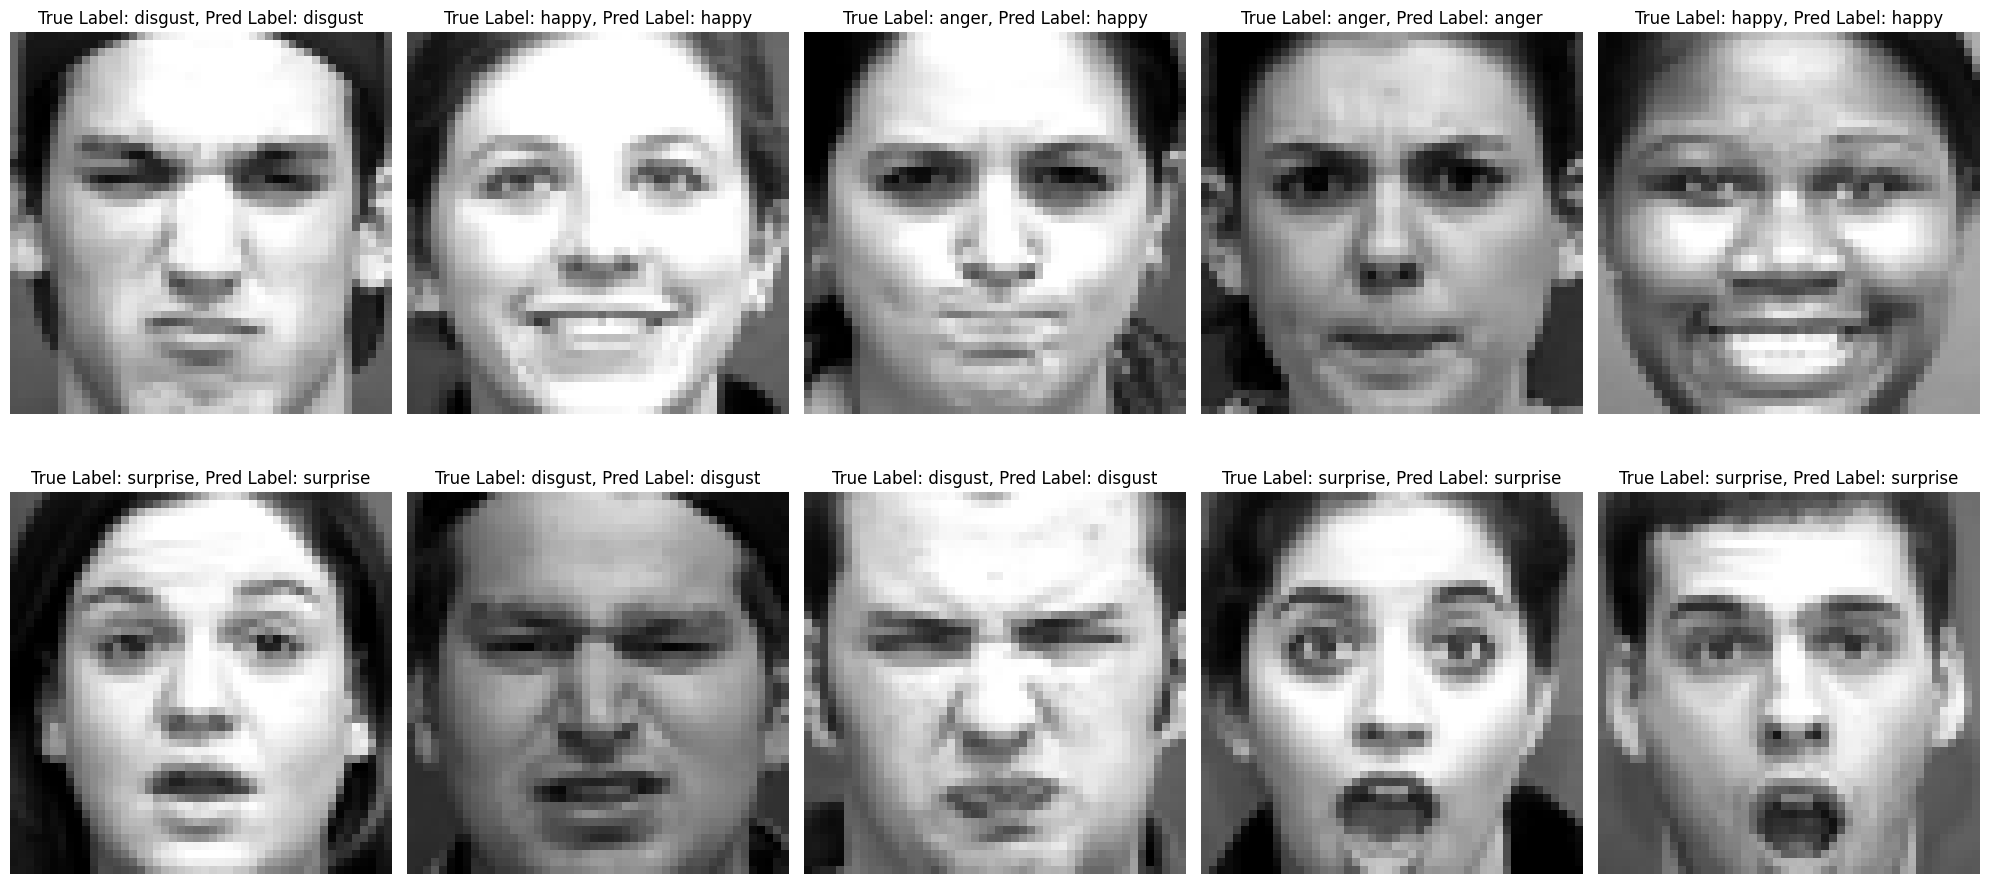

In [11]:
random_indices = random.sample(range(len(X_test)), 10)

plt.figure(figsize=(20, 10))

for i, index in zip(range(10), random_indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(cv.cvtColor(X_test[index], cv.COLOR_BGR2RGB))
    true_label = label_mapping[y_test[index]]
    pred_label = label_mapping[y_predict[index]]
    plt.title("True Label: {}, Pred Label: {}".format(true_label, pred_label))
    plt.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout()
plt.show()

In [12]:
softmax_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
softmax_model.fit(X_train_feature, y_train)

LogisticRegression(max_iter=500, multi_class='multinomial')

In [13]:
print(softmax_model.coef_)

[[ 0.02680042 -0.02758041 -0.0454977  ... -0.00383564 -0.01105194
  -0.00414773]
 [-0.00433128  0.01764668  0.02482934 ... -0.01627933 -0.0254064
  -0.01049873]
 [ 0.02133703 -0.02772847 -0.01992437 ...  0.00665344  0.03244623
   0.02094747]
 ...
 [-0.00174846 -0.0082216   0.00914585 ... -0.01391884 -0.00353794
   0.02371649]
 [-0.00419154  0.03990708  0.03603937 ...  0.01041912  0.01270861
  -0.00018977]
 [-0.03215847 -0.00181187 -0.01114719 ...  0.02509     0.0186662
  -0.0132769 ]]


In [14]:
public_test_accuracy = softmax_model.score(X_test_feature, y_test)
print("Accuracy of Softmax Regression: %.2f %%" %(public_test_accuracy * 100))

Accuracy of Softmax Regression: 100.00 %


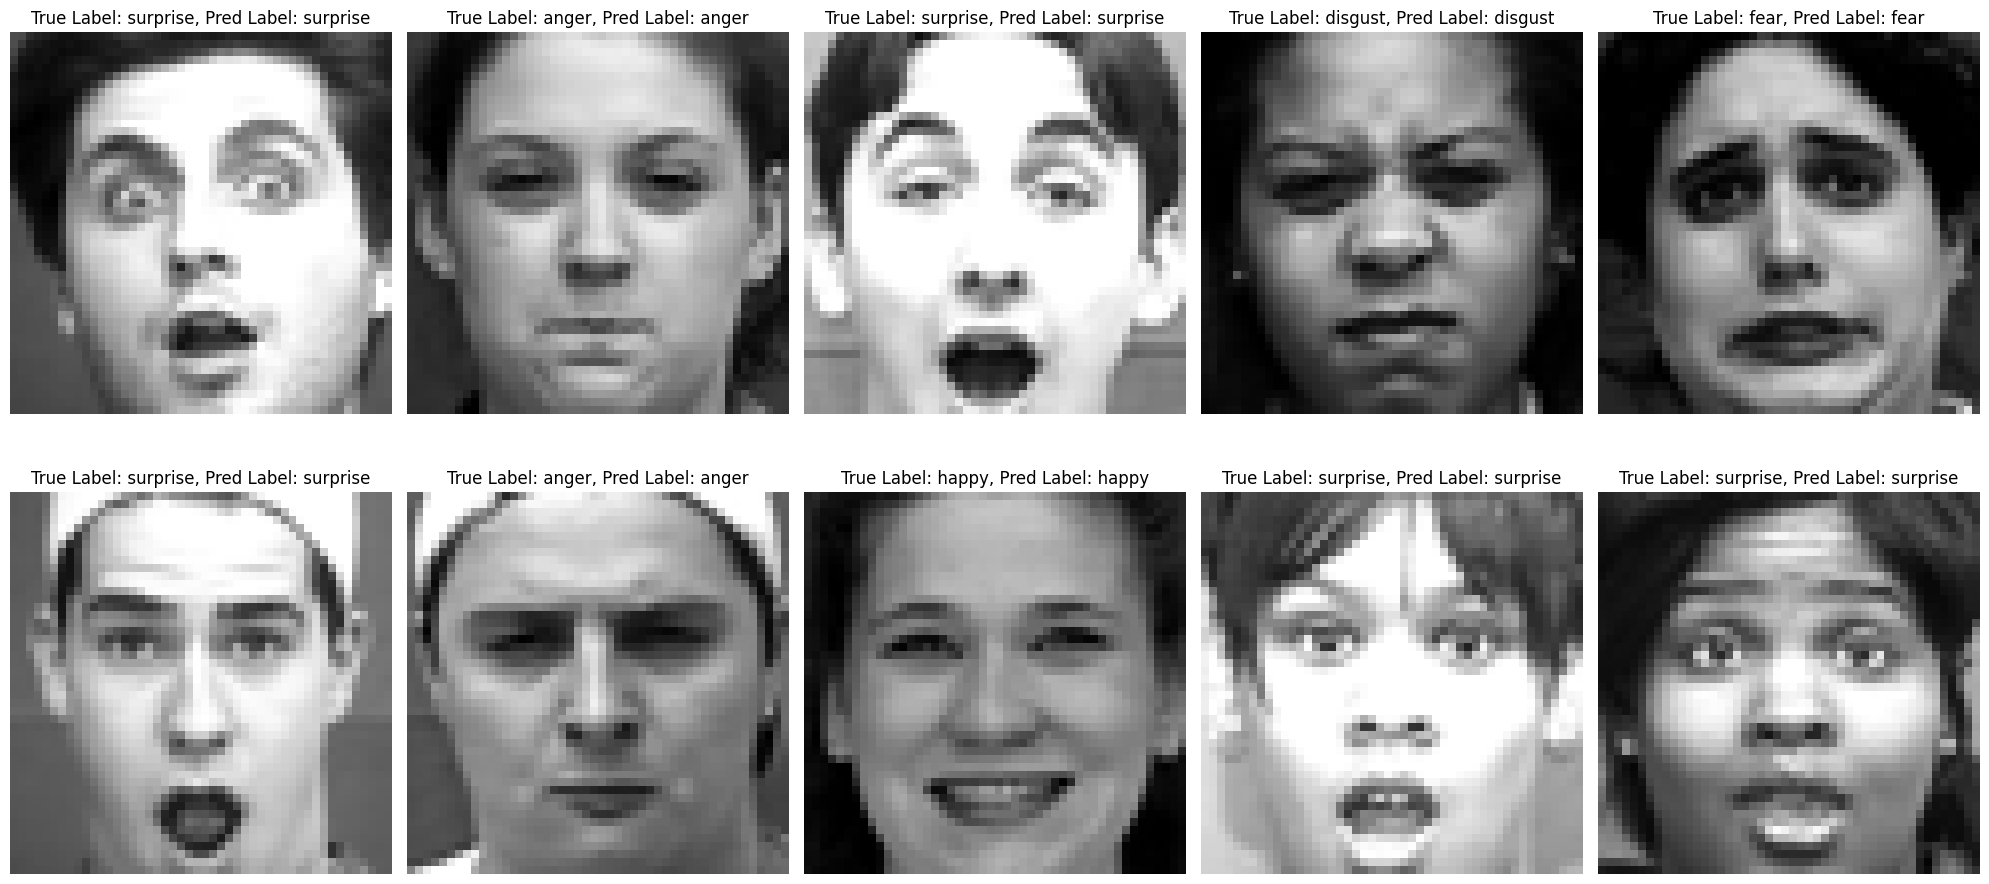

In [15]:
y_pred = softmax_model.predict(X_test_feature)
random_indices = random.sample(range(len(X_test)), 10)

plt.figure(figsize=(20, 10))

for i, index in zip(range(10), random_indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(cv.cvtColor(X_test[index], cv.COLOR_BGR2RGB))
    true_label = label_mapping[y_test[index]]
    pred_label = label_mapping[y_pred[index]]
    plt.title("True Label: {}, Pred Label: {}".format(true_label, pred_label))
    plt.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout()
plt.show()

In [16]:

def preprocess_image(image):
    if len(image.shape) > 2:
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    else:
        gray_image = image

    resized_image = cv.resize(gray_image, (64, 128))

    return resized_image

In [17]:
def pred_for_one_image(image):
    if len(image.shape) == 3:
        tmp_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    else:
        tmp_img = image

    feature, img = compute_hog_train([tmp_img])

    pred_probs = softmax_model.predict_proba(feature)[0]
    predsm = np.argmax(pred_probs)
    predsm_label = label_mapping[predsm]

    predknn = solver.predict(feature)
    predknn_label = label_mapping[predknn[0]]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB) if len(image.shape) == 3 else image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(image, cmap='gray')
    axes[1].set_title("Predicted Label by Softmax: {}".format(predsm_label))
    axes[1].axis('off')

    axes[2].imshow(image, cmap='gray')
    axes[2].set_title("Predicted Label by KNN: {}".format(predknn_label))
    axes[2].axis('off')

    fig, ax = plt.subplots(figsize=(10, 5))
    classes = list(label_mapping.values())
    ax.bar(classes, pred_probs)
    ax.set_xlabel('Class')
    ax.set_ylabel('Probability')
    ax.set_title('Softmax Prediction Probabilities')
    plt.xticks(rotation=90)
    plt.show()

In [18]:
path_dataset_folder ='/content/drive/MyDrive/New_image'

In [19]:
X_new_images = []
y_new_images = []

label_mapping = {}

sorted_folders = sorted(os.listdir(path_dataset_folder))


for idx, emotion_folder in enumerate(sorted_folders):
    emotion_path = os.path.join(path_dataset_folder, emotion_folder)
    if os.path.isdir(emotion_path):
        label_mapping[idx] = emotion_folder

        for image_file in os.listdir(emotion_path):
            image_path = os.path.join(emotion_path, image_file)
            image = cv.imread(image_path)
            image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
            X_new_images.append(image)
            y_new_images.append(idx)

# In kích thước của tập new images
print("Kích thước của tập new images:")
print("X_new_images:", len(X_new_images))
print("y_new_images:", len(y_new_images))

# In bảng ánh xạ nhãn
print("Bảng ánh xạ nhãn:")
print(label_mapping)

Kích thước của tập new images:
X_new_images: 1130
y_new_images: 1130
Bảng ánh xạ nhãn:
{0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'sadness', 6: 'surprise'}


In [20]:
New_image_features,_=compute_hog_train(X_new_images)

In [21]:
test_accuracy = softmax_model.score(New_image_features, y_new_images)
print("Accuracy of Softmax Regression: %.2f %%" %(test_accuracy * 100))

Accuracy of Softmax Regression: 25.66 %


In [24]:
knn_accuracy = best_model.score(New_image_features, y_new_images)
print("Accuracy of KNN: %.2f %%" % (knn_accuracy * 100))

Accuracy of KNN: 23.72 %
